In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tectosaur.mesh.mesh_gen
import qd
import qd.plotting
qd.configure(gpu_idx = 0, fast_plot = True)

In [11]:
n_fault = 50
L = 4000
W = 4000
m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
n_tris = m[1].shape[0]

In [12]:
qd_cfg = dict(
    # Material properties
    sm = 2e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2670,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.012,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)
    a = np.ones(n_tris * 3) * 0.010,
    b = np.ones(n_tris * 3) * 0.015,
    
    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
    
    # numerical preferences
    only_x = True, # slip/velocity/traction in the y,z directions are set = 0
    timestep_tol = 1e-3, # error tolerance for the RK45 time stepper
    
    tectosaur_cfg = dict(
        quad_mass_order = 5,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = False,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = 'INFO'
    )
)

In [13]:
model = qd.FullspaceModel(m, qd_cfg)
model.print_length_scales()

hstar (2d antiplane, erickson and dunham 2014) 3015.9289474462016
hstar_RA (2d antiplane, rubin and ampuero 2005) 1833.4649444186348
hstar_RA3D (3d strike slip, lapusta and liu 2009) 4523.893421169303
cohesive zone length scale 320.0
mesh length scale 163.26530612245006


In [14]:
traction_to_slip = qd.get_traction_to_slip(model.m, model.cfg)

In [15]:
init_conditions = qd.init_creep(model, traction_to_slip)

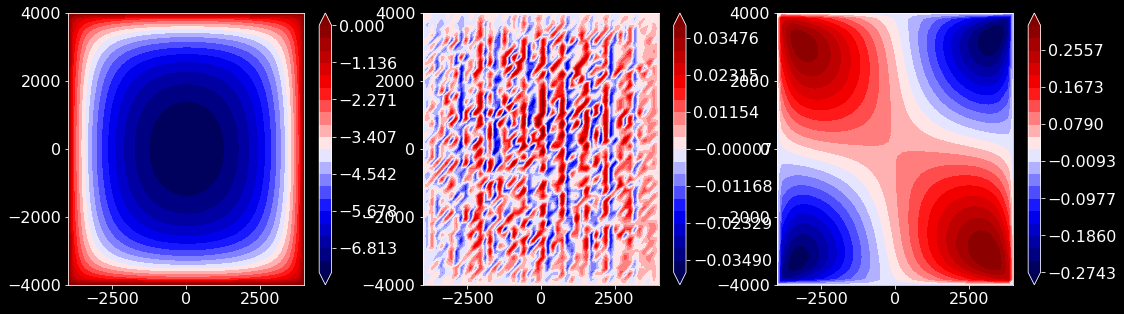

In [16]:
init_slip = init_conditions[1]
qd.plotting.plot_fields(model.m, init_slip)

In [ ]:
integrator = qd.Integrator(model, init_conditions)

In [ ]:
integrator.integrate(n_steps = 2)

In [ ]:
qd.plotting.display_full_model_state(integrator)